In [6]:
import os, sys, math, datetime
import psutil
#import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,DepthwiseConv2D, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from dotenv import load_dotenv

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

import wandb
from wandb.keras import WandbCallback
#import deeplake


In [2]:
models_dir = Path.cwd().joinpath("models")
if not models_dir.exists():
    print(f"{models_dir} does not exist.")
    models_dir.mkdir()
    print(f"Created path: {models_dir}.")


In [3]:
input_shape =(96,96,3)
classes = 2
alpha = 0.25

In [4]:
def get_model(input_shape, classes, alpha=1):
    """
    This function builds a CNN model according to the MobileNet V1 specification, using the functional API. 
    The function returns the model.
    """

    # MobileNet V1 Block
    def mobilenet_v1_block(x, filters, strides):
        # Depthwise convolution
        x = DepthwiseConv2D(kernel_size=3, strides = strides, padding= "same")(x)
        x = BatchNormalization()(x)
        x = ReLU()(x) # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters= filters, kernel_size = 1, strides=1)(x) # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)
        x = ReLU()(x) # TODO: option to change to ReLu6 or HardSwish

        return x

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters= 32* alpha, kernel_size = 3, strides=2, padding= "same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x) # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_v1_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=512 * alpha , strides=2)

    for _ in range(5): # TODO: is this the depth factor in the keras implementation?
        x = mobilenet_v1_block(x, filters = 512, strides=1)

    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=1)

    x = AvgPool2D(pool_size=7, strides=1)(x) # TODO: data_format = "channels_first" needed?
    outputs = Dense(units= classes, activation="softmax")(x) # TODO: is there a stride=1 implementation in Dense?
    
    model = Model(inputs = inputs, outputs= outputs, name= "mobilenet_v1")
    #model.summary()
    # model.compile(
    #     loss="categorical_crossentropy",
    #     optimizer=tf.keras.optimizers.Adam(0.0005),
    #     metrics =["accuracy"])
    
    return model

In [12]:
mobilenet_v1= get_model((224,224,3), classes=1000, alpha=1)

In [13]:
mltk_summary = summarize_model(mobilenet_v1)
print(mltk_summary)

Model: "mobilenet_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_28 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_27 (ReLU)             (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d_13 (Depthw  (None, 112, 112, 32)     320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_29 (Bat  (None, 112, 112, 32)    

In [14]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(
    input_shape=input_shape,
    alpha=alpha,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights=None, #'imagenet'
    input_tensor=None,
    pooling=None,
    classes=classes,
    classifier_activation='softmax',
    #**kwargs
)

In [15]:
#model = mobilenet
model = mobilenet_v1
model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [16]:
summary = model.summary(expand_nested=True)

Model: "mobilenet_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_28 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_27 (ReLU)             (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d_13 (Depthw  (None, 112, 112, 32)     320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_29 (Bat  (None, 112, 112, 32)    

In [17]:
# generate folder structure for saving the models
channels = input_shape[-1]
print(channels)


3


In [18]:
model_name = model.name
model_name = f"{model_name}_c{channels}"
print(model_name)


mobilenet_v1_c3


In [32]:
models_path = models_dir.joinpath(model_name)
if not models_path.exists():
    print(f"{models_path} does not exist.")
    models_path.mkdir()
    print(f"Created path: {models_path}.")

models_summary_path = models_dir.joinpath(model_name, f"{model_name}.txt")
models_image_path = models_dir.joinpath(model_name, f"{model_name}.png")
print(models_summary_path)
models_tf_path = models_dir.joinpath(model_name, f"{model_name}.h5")
models_tflite_path = models_dir.joinpath(model_name, f"{model_name}.tflite")
models_tflite_opt_path = models_dir.joinpath(model_name, f"{model_name}_INT8.tflite")
print(models_tflite_path)

i:\tinyml\tiny_cnn\models\mobilenet_v1_c3\mobilenet_v1_c3.txt
i:\tinyml\tiny_cnn\models\mobilenet_v1_c3\mobilenet_v1_c3.tflite


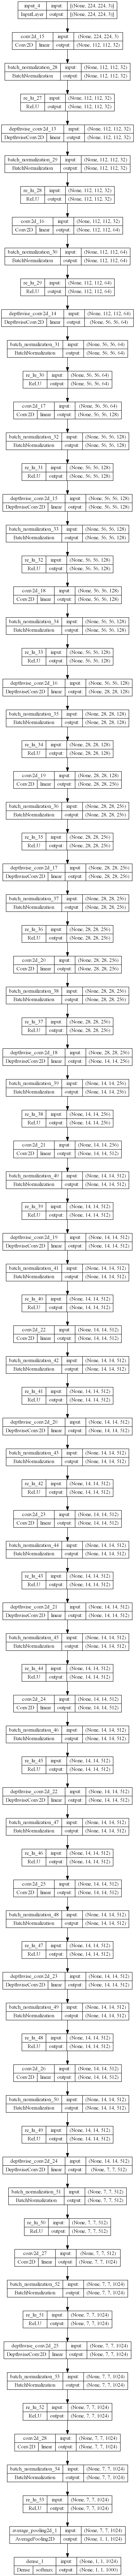

In [20]:
tf.keras.utils.plot_model(model, 
    to_file=models_image_path,
    show_shapes=True, 
    show_dtype=False,
    show_layer_names=True, 
    rankdir='TB', # TB for vertical plot, LR for horizontal plot
    expand_nested=True, 
    layer_range=None,
    dpi=200,
    show_layer_activations= True)

In [ ]:
# from tensorflow.keras.models import Model
# def  Mymodel(backbone_model, classes):
#     backbone = backbone_model
#     x = backbone.output
#     x = tf.keras.layers.Dense(classes,activation='sigmoid')(x)
#     model = Model(inputs=backbone.input, outputs=x)
#     return model

# input_shape = (224, 224, 3)
# model = Mymodel(backbone_model=tf.keras.applications.MobileNet(input_shape=input_shape, include_top=False, pooling='avg'),
#                 classes=61)

# model.summary()

In [21]:
from contextlib import redirect_stdout

with open(models_summary_path, 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [22]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.input.shape , layer.output_shape, layer.outbound_nodes, layer.compute_dtype, layer.count_params() )#layer.get_config())
    if isinstance(layer, keras.layers.InputLayer):
        print(f"Input Layer: {type(layer)}")

0 input_4 (None, 224, 224, 3) [(None, 224, 224, 3)] [<keras.engine.node.Node object at 0x00000243C26AD840>] float32 0
Input Layer: <class 'keras.engine.input_layer.InputLayer'>
1 conv2d_15 (None, 224, 224, 3) (None, 112, 112, 32) [<keras.engine.node.Node object at 0x00000243DC0D96C0>] float32 896
2 batch_normalization_28 (None, 112, 112, 32) (None, 112, 112, 32) [<keras.engine.node.Node object at 0x0000024429CE2770>] float32 128
3 re_lu_27 (None, 112, 112, 32) (None, 112, 112, 32) [<keras.engine.node.Node object at 0x0000024429D4A3B0>] float32 0
4 depthwise_conv2d_13 (None, 112, 112, 32) (None, 112, 112, 32) [<keras.engine.node.Node object at 0x0000024429E339A0>] float32 320
5 batch_normalization_29 (None, 112, 112, 32) (None, 112, 112, 32) [<keras.engine.node.Node object at 0x0000024429CF7820>] float32 128
6 re_lu_28 (None, 112, 112, 32) (None, 112, 112, 32) [<keras.engine.node.Node object at 0x0000024429DFB8B0>] float32 0
7 conv2d_16 (None, 112, 112, 32) (None, 112, 112, 64) [<keras.

In [24]:
model.layers[1].activation

<function keras.activations.linear(x)>

In [25]:
model.layers[1].get_config()

{'name': 'conv2d_15',
 'trainable': True,
 'dtype': 'float32',
 'filters': 32,
 'kernel_size': (3, 3),
 'strides': (2, 2),
 'padding': 'same',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [26]:
filters = model.layers[1].get_config()["filters"]
print(filters)

32


In [27]:
model.layers[1].weights[0].shape 

TensorShape([3, 3, 3, 32])

In [28]:
model.layers[1].weights[0].name

'conv2d_15/kernel:0'

In [33]:
model.save(models_tf_path)
#model.save("test_Mobilenet.h5")

In [34]:
reconstructed_model = keras.models.load_model(models_tf_path)

# Let's check:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )

# # The reconstructed model is already compiled and has retained the optimizer
# # state, so training can resume:
# reconstructed_model.fit(test_input, test_target)

# Conversion to TFLite

In [35]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter = tf.lite.TFLiteConverter.from_saved_model(models_path)
tflite_model = converter.convert()

# Save the model.
with open(models_tflite_path, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmparox6rhx\assets


# Conversion to TFLite with Quantization
A representative dataset is needed for quantization

In [ ]:
data_dir = Path.cwd().parent.joinpath("lemon_dataset", "docs", "data")
dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset")
dataset_path.exists()

#batch_size = 32
#img_height = 92
#img_width = 92
shuffle_seed = 42

def get_lemon_quality_dataset(dataset_path, img_width, img_height, batch_size, normalize=True):
    """ Fetches the lemon quality dataset and prints dataset info. It normalizes the image data to range [0,1] by default.

    Args: 
        dataset_path (Path): the file location of the dataset. Subfolders "train", "test", and "val" are expected.
        normalize (boolean): Normalizes the image data to range [0, 1]. Default: True

    Returns:
        (train_ds, val_ds, test_ds, class_names) (tuple(tf.datasets)): Tensorflow datasets for train, validation and test.
    
    """
    if dataset_path.exists():
        try:
            train_dir = dataset_path.joinpath("train")
            val_dir = dataset_path.joinpath( "val")
            test_dir = dataset_path.joinpath( "test")
        except:
            print(f"Please check the folder structure of {dataset_path}.")
            raise

    print("Preparing training dataset...")        
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #batch_size=1)
    )    

    class_names = train_ds.class_names


    print("Preparing validation dataset...")    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #batch_size=batch_size)
    )

    print("Preparing test dataset...")    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #batch_size=batch_size)
    )
    
    # Normalize the data to the range [0, 1]
    if normalize:
        normalization_layer = tf.keras.layers.Rescaling(1./255)

        train_ds= train_ds.map(lambda x, y: (normalization_layer(x), y))
        val_ds= val_ds.map(lambda x, y: (normalization_layer(x), y))
        test_ds= test_ds.map(lambda x, y: (normalization_layer(x), y))
    else:
        pass

    print (f"Class names: {class_names}")
    print(train_ds.element_spec)
    print(f"Normalize: {normalize}")
    return (train_ds, val_ds, test_ds, class_names)

In [ ]:
IMG_WIDTH = 96
IMG_HEIGHT = 96
BATCH_SIZE =32

train_ds, val_ds, test_ds, labels = get_lemon_quality_dataset(dataset_path, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE)

Preparing training dataset...
Found 2021 files belonging to 3 classes.
Preparing validation dataset...
Found 252 files belonging to 3 classes.
Preparing test dataset...
Found 255 files belonging to 3 classes.
Class names: ['bad_quality', 'empty_background', 'good_quality']
(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Normalize: True


In [ ]:
#rep_ds =list(train_ds.as_numpy_iterator())
#rep_ds

In [ ]:
# def representative_dataset(rep_ds):
#     for i in range(500):
#         yield(list(rep_ds[i].reshape(1,1)))
# representative_dataset(rep_ds)

In [ ]:
# Convert the model to the TensorFlow Lite format with quantization
# def representative_dataset():
#   for i in range(500):
#     yield([x_train[i].reshape(1, 1)])



In [ ]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
rep_ds = train_ds.unbatch()

In [ ]:
def representative_data_gen():
    #for input_value in train_ds.unbatch.batch(1).take(100):
    for input_value, output_value in rep_ds.batch(1).take(100):
    # Model has only one input so each data point has one element.
      print(input_value)
      yield [input_value]

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(dataset_path,
                                                      interpolation="bilinear",
                                                      image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                      #batch_size=1)
)

rescale = tf.keras.layers.Rescaling(1./255, offset= -1)                                                      
test_ds  = test_ds.map(lambda x, y: (rescale(x), y))

Found 2528 files belonging to 3 classes.


In [ ]:
test_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
repr_ds = test_ds.unbatch()
repr_ds

<_UnbatchDataset element_spec=(TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:

def representative_data_gen():
  for i_value, o_value in repr_ds.batch(1).take(48):
  #for i_value, o_value in test_ds.take(48):
  #for i_value, o_value in train_ds.take(48):
  #for i_value, o_value in repr_ds.take(48):
    yield [i_value]

# next(representative_data_gen())

In [ ]:
#converter_INT = tf.lite.TFLiteConverter.from_keras_model(model)
converter_INT = tf.lite.TFLiteConverter.from_saved_model(str(models_path))
    
# Set the optimization flag.
converter_INT.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter_INT.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_INT.inference_input_type = tf.int8
converter_INT.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
#converter_INT.representative_dataset = representative_dataset(rep_ds)
converter_INT.representative_dataset = representative_data_gen
#converter_INT.representative_dataset = rep_ds
model_tflite_opt = converter_INT.convert()

# Save the model to disk
with open(models_tflite_opt_path, 'wb') as f:
  f.write(model_tflite_opt)

In [ ]:
# # repr_ds = test_ds.unbatch()

# # def representative_data_gen():
# #   for i_value, o_value in repr_ds.batch(1).take(48):
# #     yield [i_value]
# converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)
# #converter_opt = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
# # converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
# converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
# #converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# #converter_opt.inference_input_type = tf.int8

# tflite_model_opt = converter_opt.convert()

# # Save the model.
# with open(models_tflite_opt_path, 'wb') as f:
#   f.write(tflite_model_opt)

In [ ]:
models_tflite_opt_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenet_0.25_96_c3/mobilenet_0.25_96_c3_INT8.tflite')

In [ ]:
str(models_tflite_opt_path)

'i:\\tinyml\\tiny_cnn\\models\\mobilenet_0.25_96_c3\\mobilenet_0.25_96_c3_INT8.tflite'

## Get the TFLite model size in bytes

In [ ]:
size_tfl_model = len(model_tflite_opt)
print(len(model_tflite_opt), "bytes")

299880 bytes


### Convert the TFLite model to C-byte array with xxd

In [ ]:
#open("model.tflite", "wb").write(tfl_model)
!apt-get update && apt-get -qq install xxd
#!xxd -c 60 -i model.tflite > indoor_scene_recognition.h
!xxd -c 60 -i i:\\tinyml\\tiny_cnn\\models\\mobilenet_0.25_96_c3\\mobilenet_0.25_96_c3_INT8.tflite' > model_INT.h

Der Befehl "apt-get" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "xxd" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [ ]:
for layer in model.layers:
    print(layer.name, layer.compute_dtype ,len(layer.variables) , layer.input_shape, layer.output_shape)

input_2 float32 0 [(None, 96, 96, 3)] [(None, 96, 96, 3)]
conv1 float32 1 (None, 96, 96, 3) (None, 48, 48, 8)
conv1_bn float32 4 (None, 48, 48, 8) (None, 48, 48, 8)
conv1_relu float32 0 (None, 48, 48, 8) (None, 48, 48, 8)
conv_dw_1 float32 1 (None, 48, 48, 8) (None, 48, 48, 8)
conv_dw_1_bn float32 4 (None, 48, 48, 8) (None, 48, 48, 8)
conv_dw_1_relu float32 0 (None, 48, 48, 8) (None, 48, 48, 8)
conv_pw_1 float32 1 (None, 48, 48, 8) (None, 48, 48, 16)
conv_pw_1_bn float32 4 (None, 48, 48, 16) (None, 48, 48, 16)
conv_pw_1_relu float32 0 (None, 48, 48, 16) (None, 48, 48, 16)
conv_pad_2 float32 0 (None, 48, 48, 16) (None, 49, 49, 16)
conv_dw_2 float32 1 (None, 49, 49, 16) (None, 24, 24, 16)
conv_dw_2_bn float32 4 (None, 24, 24, 16) (None, 24, 24, 16)
conv_dw_2_relu float32 0 (None, 24, 24, 16) (None, 24, 24, 16)
conv_pw_2 float32 1 (None, 24, 24, 16) (None, 24, 24, 32)
conv_pw_2_bn float32 4 (None, 24, 24, 32) (None, 24, 24, 32)
conv_pw_2_relu float32 0 (None, 24, 24, 32) (None, 24, 24, 32